<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Deployment of a model as a service with Azure Container Instances

## Table of contents <a id="table_of_content"></a>

1. [Introduction](#intro)
1. [Pre-requisites](#pre-reqs)
1. [Library import](#libraries)
1. [Azure workspace](#workspace)
  1. [SDK version](#sdk)
  1. [Workspace creation](#ws)
1. [Model retrieval and export](#model)
1. [Model deployment on Azure](#deploy)
  1. [Model registration](#register)
    1. [Without experiment](#noexp)
    1. [With an experiment](#exp)
  1. [Scoring script](#scoring)
  1. [Environment setup](#env)
  1. [Computational resources](#compute)
  1. [Web service deployment](#websvc)
1. [Testing of the web service](#test)
  1. [Using the run API](#api)
  1. [Via a raw HTTP request](#http)
  1. [Notes on web service deployment](#notes)
1. [Clean-up](#clean)
  1. [Service termination](#svcterm)
  1. [Image deletion](#imdel)
  1. [Workspace deletion](#wsdel)
1. [Next steps](#next-steps)

## 1. Introduction <a id="intro"></a>

Building a machine learning model with high precision and/or recall is very satisfying. However, it is not necessarily the end of the story. This model may need to go into production to be called in real time, and serve results to our end users. How do we go about doing that? In this notebook, we will learn:
- how to register a model on Azure
- how to create a Docker image that contains our model
- how to deploy a web service on [Azure Container Instances](https://azure.microsoft.com/en-us/services/container-instances/) using this Docker image
- how to test that our service works well, from within the notebook.

<img src="media/ACI_diagram_2.jpg" width="500" style="float: left;" alt="Web service deployment workflow">

## 2. Pre-requisites
<a id="pre-reqs"></a>

For this notebook to run properly on our machine, the following should already be in place:

* Local machine setup
  * We need to set up the "cvbp" conda environment. [These instructions](https://github.com/Microsoft/ComputerVisionBestPractices/blob/staging/image_classification/README.md) explain how to do that.


* Azure subscription setup
  * We also need an account on the Azure platform. If we do not have one, we first need to:
    * [Create an account](https://azure.microsoft.com/en-us/free/services/machine-learning/)
    * [Add a subscription](https://ms.portal.azure.com/#blade/Microsoft_Azure_Billing/SubscriptionsBlade) -- _We can start with a free one_
    * [Add a resource group](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.Resources%2Fsubscriptions%2FresourceGroups)

## 3. Library import <a id="libraries"></a>
Throughout this notebook, we will be using a variety of libraries. We are listing them here for better readibility.

In [1]:
# For automatic reloading of modified libraries
%reload_ext autoreload
%autoreload 2

# Regular python libraries
import os
import requests
import sys

# fast.ai
from fastai.vision import *
import torchvision.models as models

# Azure
import azureml.core
from azureml.core import Experiment, Workspace
from azureml.core.image import ContainerImage
from azureml.core.model import Model
from azureml.core.webservice import AciWebservice, Webservice
from azureml.exceptions import ProjectSystemException, UserErrorException

# Computer Vision repository
sys.path.extend(["..", "../..", "../../.."])
# This "sys.path.extend()" statement allows us to move up the directory hierarchy 
# and access the utils_ic and utils_cv packages
from utils_cv.generate_deployment_env import generate_yaml
from utils_ic.common import ic_root_path
from utils_ic.constants import IMAGENET_IM_SIZE
from utils_ic.image_conversion import ims2strlist
from utils_ic.imagenet_models import model_to_learner

## 4. Azure workspace <a id="workspace"></a>

### 4.A SDK version <a id="sdk"></a>

Before we start, let's check which version of the Azure SDK we are working with.

In [2]:
# Check core SDK version number
print(f"Azure ML SDK Version: {azureml.core.VERSION}")

### 4.B Workspace creation <a id="ws"></a>
Now that we have our environment and proper libraries in place, let's load an existing workspace or create a new one on our Azure account, and save it to a local configuration file (`./aml_config/config.json`).

If it is the first time we create a workspace, or if we are missing our `config.json` file, we need to provide the appropriate:
- subscription ID: the ID of the Azure subscription we are using
- resource group: the name of the resource group in which our workspace resides
- workspace_region: the geographical area in which our workspace resides (examples are available [here](https://azure.microsoft.com/en-us/global-infrastructure/geographies/))
- workspace_name: the name of the workspace we want to create or retrieve.

In [3]:
# Let's define these variables here - These pieces of information can be found on the portal
subscription_id = os.getenv("SUBSCRIPTION_ID", default="<our_subscription_id>")
resource_group =  os.getenv("RESOURCE_GROUP", default="<our_resource_group>")
workspace_name = os.getenv("WORKSPACE_NAME", default="<our_workspace_name>")  # (e.g. "myworkspace")
workspace_region = os.getenv("WORKSPACE_REGION", default="<our_workspace_region>")  # (e.g. "westus2")    

try:
    # Let's load the workspace from the configuration file
    ws = Workspace.from_config()
    print("Workspace was loaded successfully from the configuration file")
except (UserErrorException, ProjectSystemException):
    # or directly from Azure, if it already exists (exist_ok=True).
    # If it does not exist, let's create a workspace from scratch
    ws = Workspace.create(name=workspace_name,
                          subscription_id=subscription_id,
                          resource_group=resource_group,
                          location=workspace_region,
                          create_resource_group=True,
                          exist_ok=True
                         )
    ws.write_config()
    print("Workspace was loaded successfully from Azure")

Let's check that the workspace is properly loaded

In [4]:
# Print the workspace attributes
print(f'Workspace name: {ws.name}\n \
      Azure region: {ws.location}\n \
      Subscription id: {ws.subscription_id}\n \
      Resource group: {ws.resource_group}')

We can see this workspace on the Azure portal by sequentially clicking on:
- Resource groups, and clicking the one we referenced above

<img src="media/resource_group.jpg" width="800" alt="Azure portal view of resource group">

- Workspace_name

<img src="media/workspace.jpg" width="800" alt="Azure portal view of workspace">

## 5. Model retrieval and export <a id="model"></a>

For demonstration purposes, we will use here a ResNet18 model, pretrained on ImageNet. The following steps would be the same if we had trained a model locally (cf. [**01_training_introduction.ipynb**](https://github.com/Microsoft/ComputerVisionBestPractices/blob/staging/image_classification/notebooks/01_training_introduction.ipynb) notebook for details).

Let's first retrieve the model.

In [5]:
learn = model_to_learner(models.resnet18(pretrained=True), IMAGENET_IM_SIZE)

To be able to use this model, we need to export it to our local machine. We store it in an `outputs/` subfolder.

In [6]:
current_directory = os.getcwd()
output_folder = os.path.join(current_directory, 'outputs')
MODEL_NAME = 'im_classif_resnet18'  # Name we will give our model both locally and on Azure
PICKLED_MODEL_NAME = MODEL_NAME + '.pkl'
os.makedirs(output_folder, exist_ok=True)

learn.export(os.path.join(output_folder, PICKLED_MODEL_NAME))

## 6. Model deployment on Azure <a id="deploy"></a>

### 6.A Model registration <a id="register"></a>

Our final goal is to deploy our model as a web service. To do so, we need to first register it in our workspace, i.e. place it in our workspace's model registry. We can do this in 2 ways:
1. register the model directly
2. upload the model on Azure and then register it there.

The advantage of the first method is that it does not require the setup of an experiment or of any runs. The advantage of the second fashion is that we can keep track of the models that we used or trained in a given experiment, and understand where the ones we ended up registering come from.

The cells below show each of the methods.

#### 6.A.a Without experiment <a id="noexp"></a>

We leverage the `register` method from the Azure ML `Model` object. For that, we just need the location of the model we saved on our local machine, its name and our workspace object.

In [7]:
model = Model.register(
    model_path = os.path.join('outputs', PICKLED_MODEL_NAME),
    model_name = MODEL_NAME,
    tags = {"Model": "Pretrained ResNet18"},
    description = "Image classifier",
    workspace = ws
)

Registering model im_classif_resnet18


#### 6.A.b With an experiment <a id="exp"></a>

An experiment contains a series of trials called `Runs`. A run typically contains some tasks, such as training a model, etc. Through a run's methods, we can log several metrics such as training and test loss and accuracy, and even tag our run. The full description of the run class is available [here](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.run.run?view=azure-ml-py). In our case, however, we just need the run to attach our model file to our workspace and experiment.

We do this by using `run.upload_file()` and `run.register_model()`, which takes:
- a `model_name` that represents what our model does
- and the `model_path` relative to the run.

Using `run.upload_file()` and specifying the `outputs/` folder allows us to check the presence of the uploaded model on the Azure portal. This is especially convenient when we want to try different versions of a model, or even different models entirely, and keep track of them all, even if we end up registering only the best performing one.

Let's first create a new experiment. If an experiment with the same name already exists in our workspace, the run we will generate will be recorded under that already existing experiment.

In [8]:
# Create a new/Retrieve an existing experiment
experiment_name = 'image-classifier-webservice'
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"New/Existing experiment:\n \
      --> Name: {experiment.name}\n \
      --> Workspace name: {experiment.workspace.name}")

New/Existing experiment:
       --> Name: image-classifier-webservice
       --> Workspace name: ws2_tutorials2


In [9]:
# Initialize the run
run = experiment.start_logging(snapshot_directory=None)
# "snapshot_directory=None" prevents a snapshot from being saved -- this helps keep the amount of storage used low

Now that we have launched our run, we can see our experiment on the Azure portal, under `Experiments` (in the left-hand side list).

<img src="media/experiment.jpg" width="800" alt="Azure portal view of experiment">

We can now attach our local model to our workspace and experiment.

In [10]:
# Upload the model (.pkl) file to Azure
run.upload_file(
    name=os.path.join('outputs', PICKLED_MODEL_NAME), 
    path_or_stream=os.path.join(current_directory, 'outputs', PICKLED_MODEL_NAME)
)

In [11]:
# Register the model with the workspace
model = run.register_model(
    model_name=MODEL_NAME,
    model_path=os.path.join('outputs', PICKLED_MODEL_NAME),
    tags = {"Model": "Pretrained ResNet18"},
)
# !!! We need to make sure that the model name we use here is the same as in the scoring script below !!!

Now that the model is uploaded and registered, we can see it on the Azure platform, under `Outputs` and `Models`

<div class="inline-block">
    <img src="media/uploaded_model.jpg" width="800" alt="Azure portal view of the Outputs/ folder">
</div>

<div class="inline-block">
    <img src="media/models.jpg" width="800" alt="Azure portal view of the Models section">
</div>

We can also check that it is programatically accessible

In [12]:
print(f"Model:\n --> Name: {model.name}\n \
      --> ID: {model.id}\n \
      --> Path:{model._get_model_path_remote(model.name, model.version, ws)}")

Model:
 --> Name: im_classif_resnet18
       --> ID: im_classif_resnet18:68
       --> Path:azureml-models\im_classif_resnet18\68\im_classif_resnet18.pkl


In [13]:
run.get_file_names()

['outputs/im_classif_resnet18.pkl']

If we are also interested in verifying which model we uploaded, we can download it to our local machine

In [14]:
model.download()

'im_classif_resnet18.pkl'

<i><b>Note:</b> If we ran the cells in both the "with an experiment" and "without experiment" sections, we got 2 iterations of the same model registered on Azure. This is not a problem as any operation that we perform on the "model" object, later on, will be associated with the latest version of the model that we registered. To clean things up, we can go to the portal, select the model we do not want and click the "Delete" button. In general, we would register the model using only one of these 2 methods. </i>

We are all done with our model registration, so we can close our run.

In [15]:
# Close the run
run.complete()

In [16]:
# Access the portal
run

Experiment,Id,Type,Status,Details Page,Docs Page
image-classifier-webservice,ff4a55d5-1916-4131-ac92-8658789c4f8f,,Completed,Link to Azure Portal,Link to Documentation


### 6.B Scoring script <a id="scoring"></a>
For the web service to return predictions on a given input image, we need to provide it with instructions on how to use the model we just registered. These instructions are stored in the scoring script.

This script must contain two required functions, `init()` and `run(input_data)`:
- In the `init()` function, we typically load the model into a global object. This function is executed only once when the Docker container is started.
- In the `run(input_data)` function, the model is used to predict a value based on the input data. The input and output of `run` typically use JSON as serialization and de-serialization format but we are not limited to that.

<i><b>Note:</b> The "run()" function here is different from the "run" object we created in our experiment</i>

This file must also be stored in the current directory.

In [17]:
scoring_script = "score.py"

In [18]:
%%writefile $scoring_script
# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.

import json

from base64 import b64decode
from io import BytesIO

from azureml.core.model import Model
from fastai.vision import *

def init():
    global model
    model_path = Model.get_model_path(model_name='im_classif_resnet18')
    # ! We cannot use MODEL_NAME here otherwise the execution on Azure will fail !
    
    model_dir_path, model_filename = os.path.split(model_path)
    model = load_learner(path=model_dir_path, fname=model_filename)


def run(raw_data):

    # Expects raw_data to be a list within a json file
    result = []    
    
    for im_string in json.loads(raw_data)['data']:
        im_bytes = b64decode(im_string)
        try:
            im = open_image(BytesIO(im_bytes))
            pred_class, pred_idx, outputs = model.predict(im)
            result.append({"label": str(pred_class), "probability": str(outputs[pred_idx].item())})
        except Exception as e:
            result.append({"label": str(e), "probability": ''})
    return result


Writing score.py


### 6.C Environment setup <a id="env"></a>

In order to make predictions on the Azure platform, it is important to create an environment as similar as possible to the one in which the model was trained. Here, we use a fast.ai pretrained model that also requires pytorch and a few other libraries. To re-create this environment, we use a [Docker container](https://www.docker.com/resources/what-container). We configure it via a yaml file that will contain all the conda dependencies needed by the model. This yaml file is a subset of  `image_classification/environment.yml`.

<i><b>Note:</b> If we had trained our model locally, we would have created a yaml file that contains the same libraries as what is installed on our local machine.</i>

In [19]:
# Create a deployment-specific yaml file from image_classification/environment.yml
generate_yaml(
    directory=ic_root_path(), 
    ref_filename='environment.yml',
    needed_libraries=['pytorch', 'spacy', 'fastai', 'dataclasses'],
    conda_filename='myenv.yml'
)

# Note: Take a look at the generate_yaml() function for details on how to create your yaml file from scratch

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- pytorch==1.0.0
- fastai==1.0.48
- spacy
- dataclasses
channels:
- defaults
- conda-forge
- pytorch
- fastai



There are different ways of creating a Docker image on Azure. Here, we create it separately from the service it will be used by. This way of proceeding gives us direct access to the Docker image object. Thus, if the service deployment fails, but the Docker image gets deployed successfully, we can try deploying the service again, without having to create a new image all over again.

In [20]:
# Configure the Docker image
image_config = ContainerImage.image_configuration(
    execution_script = "score.py",
    runtime = "python",
    conda_file = "myenv.yml",
    description = "Image with fast.ai Resnet18 model (fastai 1.0.48)",
    tags = {'training set': "ImageNet", 
            'architecture': "CNN ResNet18",
            'type': 'Pretrained'}
)

In [21]:
# Create the Docker image
docker_image = ContainerImage.create(
    name = "image-classif-resnet18-f48",
    models = [model], # the model is passed as part of a list
    image_config = image_config,
    workspace = ws
)
# The image name should not contain more than 32 characters, and should not contain any spaces, dots or underscores
# A Docker image can contain several model objects. Here, we just have one.

Creating image


In [22]:
%%time
docker_image.wait_for_creation(show_output = True)  # This can take up to 12 min

Running................................................................................................
SucceededImage creation operation finished for image image-classif-resnet18-f48:28, operation "Succeeded"
Wall time: 9min 1s


When the image gets successfully created, we expect to see:

`Creating image
Running .....
SucceededImage creation operation finished for image <docker_image_name>, operation "Succeeded"
Wall time: Xmin`

It happens, sometimes, that the deployment of the Docker image fails. Re-running the previous command typically solves the problem. If it doesn't, however, we can run the following one and inspect the deployment logs.

In [23]:
print(ws.images["image-classif-resnet18-f48"].image_build_log_uri)

### 6.D Computational resources <a id="compute"></a>

In this notebook, we use [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/container-instances-overview) (ACI) which are good for quick and [cost-effective](https://azure.microsoft.com/en-us/pricing/details/container-instances/) development/test deployment scenarios.

To set them up properly, we need to indicate the number of CPU cores and the amount of memory we want to allocate to our web service. Optional tags and descriptions are also available for us to identify the instances in AzureML when looking at the `Compute` tab in the Azure Portal.

<i><b>Note:</b> For production workloads, it is better to use [Azure Kubernetes Service](https://docs.microsoft.com/en-us/azure/aks/) (AKS) instead. We will demonstrate how to do this in the next notebook (to be published).<i>

In [24]:
# Create a deployment configuration with 1 CPU and 5 gigabytes of RAM
aci_config = AciWebservice.deploy_configuration(
    cpu_cores=1, 
    memory_gb=5, 
    tags={'webservice': 'image classification model (fastai 1.0.48)'},
    description='This service classifies images into 1000 different groups.'
)

### 6.E Web service deployment <a id="websvc"></a>

The final step to deploying our web service is to call `WebService.deploy_from_image()`. This function uses the Docker image and the deployment configuration we created above to perform the following:

- Deploy the docker image to an Azure Container Instance
- Call the `init()` function in our scoring file
- Provide an HTTP endpoint for scoring calls

The `deploy_from_image` method requires the following parameters:

- workspace: the workspace containing the service
- name: a unique name used to identify the service in the workspace
- image: a docker image object that contains the environment needed for scoring/inference
- deployment_config: a configuration object describing the compute type

Azure Container Instances have no associated ComputeTarget, so we do not specify any here. Remember, we already provided information on the number of CPUs and the amount of memory needed in the service configuration file above.

<i><b>Note:</b> The web service creation can take a few minutes</i>

In [25]:
# Define how to deploy the web service
service_name = 'im-classif-websvc'
service = Webservice.deploy_from_image(
    workspace=ws,
    name=service_name,
    image=docker_image,
    deployment_config=aci_config
)

Creating service


An alternative way of deploying the service is to deploy from the model directly. In that case, we would need to provide the docker image configuration object (image_config), and our list of models (just one of them here).
The advantage of `deploy_from_image` over <a href="https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice(class)?view=azure-ml-py#deploy-from-model-workspace--name--models--image-config--deployment-config-none--deployment-target-none-">deploy_from_model</a> is that the former allows us
to re-use the same Docker image in case the deployment of this service fails, or even for other
types of deployments, as we will see in the next notebook (to be pushlished).

In [26]:
# Deploy the web service
service.wait_for_deployment(show_output=True)

Running.....................................
SucceededACI service creation operation finished, operation "Succeeded"


When successful, we expect to see the following:

`
Creating service
Running .....
SucceededACI service creation operation finished, operation "Succeeded"`

In the case where the deployment is not successful, we can look at the image and service logs to debug. [These instructions](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-troubleshoot-deployment) can also be helpful.

In [ ]:
# Access the service logs
# print(service.get_logs())

In [27]:
# Retrieve the service status
print(f"Service {service.name} is _{service.state}_ and available at {service.scoring_uri}")

We can also check the presence and status of both our new Docker image and web service on the Azure portal, under the `Images` and `Deployments` tabs, respectively.


<img src="media/docker_images.jpg" width="800" alt="Azure portal view of the Images section">
<img src="media/deployments.jpg" width="800" alt="Azure portal view of the Deployments section">

## 7. Testing of the web service <a id="test"></a>

Our web service is now up and running. To make sure that it is working as expected, let's test it.

We first need to retrieve test images and to pre-process them into the format expected by our model. A service typically expects input data to be in a JSON serializable format. Here, we use our own `ims2strlist()` function to transform our .jpg images into strings of bytes.

In [28]:
# Convert images to json object
images_fname_list = [os.path.join(ic_root_path(), 'notebooks', 'deployment', 'test_images', 'im_11.jpg'), 
                     os.path.join(ic_root_path(), 'notebooks', 'deployment', 'test_images', 'im_97.jpg')]
im_string_list = ims2strlist(images_fname_list)
test_samples = json.dumps({"data": im_string_list})

### 7.A Using the `run` API <a id="api"></a>

Our data are now properly formatted. We can send them to our web service.

In [29]:
# Predict using the deployed model
result = service.run(test_samples)

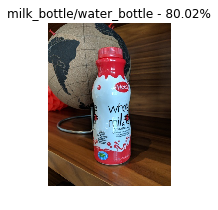

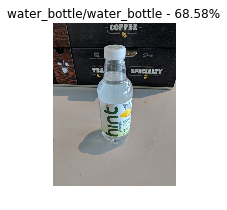

In [30]:
# Plot the results
actual_labels = ['milk_bottle', 'water_bottle']
for k in range(len(result)):
    title = "{}/{} - {}%".format(actual_labels[k], result[k]['label'], 
                                 round(100.*float(result[k]['probability']), 2))
    open_image(images_fname_list[k]).show(title=title)

### 7.B Via a raw HTTP request <a id="http"></a>

In [31]:
# Send the same test data
payload = {"data": im_string_list}
resp = requests.post(service.scoring_uri, json=payload)

# Alternative way of sending the test data
# headers = {'Content-Type':'application/json'}
# resp = requests.post(service.scoring_uri, test_samples, headers=headers)

print(f"POST to url: {service.scoring_uri}")
print(f"Prediction: {resp.text}")

Prediction: [{"label": "water_bottle", "probability": "0.8001841306686401"}, {"label": "water_bottle", "probability": "0.68577641248703"}]


### 7.C Notes on web service deployment <a id="notes"></a>

As we discussed above, Azure Container Instances tend to be used to develop and test deployments. They are typically configured with CPUs, which usually suffice when the number of requests per second is not too high. When working with several instances, we can configure them further by specifically [allocating CPU resources](https://docs.microsoft.com/en-us/azure/container-instances/container-instances-container-groups#deployment) to each of them.

For production requirements, i.e. when &gt; 100 requests per second are expected, we recommend deploying models to Azure Kubernetes Service (AKS). It is a convenient infrastructure as it manages hosted Kubernetes environments, and makes it easy to deploy and manage containerized applications without container orchestration expertise. It also supports deployments with CPU clusters and deployments with GPU clusters, the latter of which are [more economical and efficient](https://azure.microsoft.com/en-us/blog/gpus-vs-cpus-for-deployment-of-deep-learning-models/) when serving complex models such as deep neural networks, and/or when traffic to the endpoint is high.

We will see an example of this in the next notebook (to be published).

## 8. Clean up <a id="clean"></a>

Throughout the notebook, we used a workspace and Azure container instances.

When we first created our workspace, 4 extra resources were automatically added to it:
- A container registry, which hosts our Docker images
- A storage account, in which our output files get stored
- Application Insights, which allows us to monitor the health of and traffic to our web service, as we will see in the next notebook
- A key vault, which stores our credentials.

In this notebook, we also hosted our web service on container instances. Overall, during the time it took us to run this notebook (assuming ~ 1h), the cost we incurred was of less than $3.

To get a better sense of pricing, we can refer to this [calculator](https://azure.microsoft.com/en-us/pricing/calculator/). We can also navigate to the [Cost Management + Billing](https://ms.portal.azure.com/#blade/Microsoft_Azure_Billing/ModernBillingMenuBlade/Overview) pane on the portal, click on our subscription ID, and click on the Cost Analysis tab to check our credit usage.

In order not to incur extra costs, let's now delete the resources we no longer need.

### 8.A Service termination <a id="svcterm"></a>

Now that we have verified that our web service works well on ACI, we can delete it. This helps reduce [costs](https://azure.microsoft.com/en-us/pricing/details/container-instances/), since the container group we were paying for no longer exists, and allows us to keep our workspace clean.

In [32]:
service.delete()

At this point, the main resource we are paying for is the <b>Standard</b> Azure Container Registry (ACR), which contains our Docker image, and came as a default when we created our workspace. Details on pricing are available [here](https://azure.microsoft.com/en-us/pricing/details/container-registry/).

### 8.B Image deletion <a id="imdel"></a>

We may decide to use our Docker image in a separate ACI or even in an AKS deployment. In that case, we should keep it available in our workspace. However, if we no longer have a use for it, we can delete it.

In [ ]:
# docker_image.delete()

### 8.C Workspace deletion <a id="wsdel"></a>

If our goal is to continue using our workspace, we should keep it available. On the contrary, if we plan on no longer using it and its associated resources, we can delete it.

<i><b>Note:</b> Deleting the workspace will delete all the experiments, outputs, models, Docker images, deployments, etc. that we created in that workspace</i>

In [ ]:
# ws.delete(delete_dependent_resources=True)
# This deletes our workspace, the container registry, the account storage, Application Insights and the key vault

## 9. Next steps <a id="next-steps"></a>

In the next notebook (to be published), we will leverage the same Docker image, and deploy our model on AKS. We will also learn how a Flask app, with an interactive user interface, can be used to call our web service.